In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import datetime
import math
from scipy.ndimage.interpolation import shift
import shapely.wkt
from scipy.stats import pearsonr,spearmanr,kendalltau,linregress
from scipy.optimize import curve_fit 

warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=1.4) 
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

from sklearn.metrics import r2_score


In [2]:
def plot_correlations(df_all, fig_title,correlation_type):
    #make the correlation matrix
    corrMatrix = df_all.corr(method=correlation_type)
    
    #plot it
    fig,ax=plt.subplots(figsize=(25,25))
    sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic', annot_kws={'fontsize':28})
    plt.title(fig_title, fontsize=20)
    plt.show()

In [3]:
def scatter_plot(df_plot,x_plot,y_plot,point_hue, point_style, point_size, point_size_range,plot_title):
    fig,ax=plt.subplots(figsize=(10,10))
    sns.scatterplot(data =df_plot, x=x_plot,y=y_plot,hue=point_hue,
                    style=point_style,size=point_size,sizes=point_size_range,ax=ax,cmap='jet')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.title(plot_title)
    plt.show()

In [4]:
#IN df_to_shift: the dataframe we want to shift
#IN ndays: how many days we want to shift, ndays>0 shift forward, ndays<0 shift backward
def shift_ndays(df_to_shift,ndays,name_col_to_shift, name_shifted_col):
    df_shifted = df_to_shift.set_index(pd.to_datetime(df_to_shift['day'])).drop(columns=['day'])
    df_shifted=df_shifted.resample('24H',origin='start').asfreq()
    #process some daily changes in FRP
    for ii in range(len(name_shifted_col)):
        df_shifted[name_shifted_col[ii]] = df_shifted[name_col_to_shift[ii]].shift(ndays)
    inds = df_shifted.index.isin(df_to_shift['day'])
    return df_shifted[inds].reset_index()

In [5]:
# Medium post on error metrics https://towardsdatascience.com/time-series-forecast-error-metrics-you-should-know-cc88b8c67f27
def RMSE(y_pred,y_test):
    return np.sqrt(np.mean(((y_pred)-(y_test))**2))

def MAD(y_pred,y_test): #aka mean error
    return np.mean(np.abs(y_pred-y_test))

def mean_percent_error(y_pred,y_test):
    return(np.mean(np.abs(100*(y_pred-y_test)/y_test)))

def fractional_error(y_pred, y_test):
    num=np.sum(np.abs(y_pred-y_test))
    denom=np.sum((y_pred+y_test)/2)
    return(num/denom)

def mdrae(y_test, y_pred, bnchmrk):
    return np.median(np.abs(y_test - y_pred)/np.abs(y_test - bnchmrk))

def REC(y_pred, y_test):
    percent_error = np.abs((y_pred-y_test)/y_test)*100
    thresholds = np.linspace(0,300, 61) #5% increments

    #percent_error = np.abs(y_pred-y_test)
    #thresholds = np.linspace(0, 0.5e-6, 61) #5% increments
    acc = np.zeros(thresholds.shape)
    for ii in range(len(thresholds)):
        n_correct = len(percent_error[percent_error<=thresholds[ii]])
        acc[ii] = n_correct*100/len(y_test)
    return thresholds, acc

def AUC(acc):
    return(np.sum(acc*5)) #left hand approximation, assuming bins are 5 wide

### Aggregation

In [18]:


path_features='/data2/lthapa/ML_daily/fire_features/'
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
inci_name_list = ['AUGUST COMPLEX','BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH','EAST TROUBLESOME']
#inci_name_list=['AUGUST COMPLEX','BOBCAT', 'DOLAN','CREEK', 'LAKE',]
#inci_name_list = ['BOBCAT','DOLAN','LAKE']
for ii in range(len(inci_name_list)):
    file_prefix = inci_name_list[ii].lower().replace(' ', '_')
    print(file_prefix)
    #load in the data
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
    #do the shift
    rave_shifted = shift_ndays(rave, 1, ['Mean_FRP'], ['Yesterday_FRP'])
    print(rave_shifted[['day','Mean_FRP','Yesterday_FRP']].values)
  
   
    #features[features['IMERG.FINAL.v6_FFMC']==0] = np.nan

august_complex
[[Timestamp('2020-08-16 12:00:00') 5089.904594482336 nan]
 [Timestamp('2020-08-17 12:00:00') 1195.290695807585 5089.904594482336]
 [Timestamp('2020-08-18 12:00:00') 95149.59107765512 1195.290695807585]
 [Timestamp('2020-08-19 12:00:00') 225709.73020336044 95149.59107765512]
 [Timestamp('2020-08-20 12:00:00') 99571.7543028517 225709.73020336044]
 [Timestamp('2020-08-21 12:00:00') 63414.56925390643 99571.7543028517]
 [Timestamp('2020-08-22 12:00:00') 23864.23607995302 63414.56925390643]
 [Timestamp('2020-08-23 12:00:00') 23128.57741835281 23864.23607995302]
 [Timestamp('2020-08-24 12:00:00') 21857.86148073783 23128.57741835281]
 [Timestamp('2020-08-25 12:00:00') 37896.36762232749 21857.86148073783]
 [Timestamp('2020-08-26 12:00:00') 17552.607326033623 37896.36762232749]
 [Timestamp('2020-08-27 12:00:00') 16855.027412523345 17552.607326033623]
 [Timestamp('2020-08-28 12:00:00') 16018.533047650268 16855.027412523345]
 [Timestamp('2020-08-29 12:00:00') 8365.113544541882 16018

In [6]:
days_all = pd.DataFrame()
names_all = pd.DataFrame()
rave_all = pd.DataFrame()
smops_all = pd.DataFrame()
pws_all = pd.DataFrame()
esi_all = pd.DataFrame()
fwi_all = pd.DataFrame()
hrrr_ws_all = pd.DataFrame()
fuels_all = pd.DataFrame()
ncar_all= pd.DataFrame()

path_features='/data2/lthapa/ML_daily/fire_features/'
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12
inci_name_list = ['AUGUST COMPLEX','BOBCAT', 'DOLAN', 'HOLIDAY FARM','CREEK', 'LAKE', 'CAMERON PEAK', 'PINE GULCH','EAST TROUBLESOME']
#inci_name_list=['AUGUST COMPLEX','BOBCAT', 'DOLAN','CREEK', 'LAKE',]
#inci_name_list = ['BOBCAT','DOLAN','LAKE']
for ii in range(len(inci_name_list)):
    file_prefix = inci_name_list[ii].lower().replace(' ', '_')
    print(file_prefix)

    #load in the data
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
    hrrr_ws = pd.read_csv(path_features+file_prefix+'_Daily_HRRR_ws_'+str(start_time)+'Z_day_start.csv')
    smops = pd.read_csv(path_features+file_prefix+'_Daily_SMOPS_'+str(start_time)+'Z_day_start.csv')
    fwi = pd.read_csv(path_features+file_prefix+'_Daily_IMERG_FWI_NoAve_'+str(start_time)+'Z_day_start.csv')
    #fwi = pd.read_csv(path_features+file_prefix+'_Daily_IMERG_FWI_'+str(start_time)+'Z_day_start.csv')
    esi = pd.read_csv(path_features+file_prefix+'_Daily_ESI_'+str(start_time)+'Z_day_start.csv')
    pws = pd.read_csv(path_features+file_prefix+'_Daily_PWS_'+str(start_time)+'Z_day_start.csv')
    fuels = pd.read_csv(path_features+file_prefix+'_Daily_COARSE990_FUEL_FWI_'+str(start_time)+'Z_day_start.csv')
    ncar=pd.read_csv(path_features+file_prefix+'_Daily_NCAR_Moisture_'+str(start_time)+'Z_day_start.csv')

    #do some derived stuff
    pws['PWS_mult'] = np.maximum(1,pws['PWS'].values) #relu-like function
    
    hrrr_ws['PWS_HD0W0'] = pws['PWS_mult']*hrrr_ws['hd0w0']
    hrrr_ws['PWS_VPD'] = pws['PWS_mult']*hrrr_ws['vpd_2m']

    hrrr_ws['sm0w0'] = (1-smops['Blended_SM'])*hrrr_ws['wind_speed']
    hrrr_ws['ffmc0w0'] = (fwi['IMERG.FINAL.v6_FFMC']/100)*hrrr_ws['wind_speed']
    hrrr_ws['dmc0w0'] = fwi['IMERG.FINAL.v6_DMC']*hrrr_ws['wind_speed']


    #derive some additional stuff
    names = pd.DataFrame({'name':[inci_name_list[ii]]*len(rave)})
    days = pd.DataFrame({'day':np.zeros(len(rave))})
    days['day'] = rave['day'].values

    #do the shift
    rave_shifted = shift_ndays(rave, 1, ['Mean_FRP'], ['Yesterday_FRP'])
    hrrr_ws_shifted = shift_ndays(hrrr_ws, 1, ['vpd_2m','hd0w0','hwp','PWS_HD0W0','PWS_VPD','sm0w0','ffmc0w0','dmc0w0'],
                                              ['Yesterday_VPD','Yesterday_hd0w0', 'Yesterday_hwp','Yesterday_PWS_HD0W0','Yesterday_PWS_VPD',
                                               'Yesterday_sm0w0','Yesterday_ffmc0w0','Yesterday_dmc0w0'])
    hrrr_ws_shifted['rh'] = hrrr_ws_shifted['e_2m']/hrrr_ws_shifted['esat_2m']
    ncar_shifted = shift_ndays(ncar,1,['FMCG2D','FMCGLH2D'],['Yesterday_FMCG2D','Yesterday_FMCGLH2D'])
    


    #print(hrrr_ws_shifted.columns)

    inds_active = np.where(rave_shifted['Mean_FRP']>10)[0] #this is the threshold I used at NOAA

    days_all = pd.concat([days_all, days.iloc[inds_active]],axis=0)
    names_all = pd.concat([names_all, names.iloc[inds_active]],axis=0)
    rave_all = pd.concat([rave_all, rave_shifted.iloc[inds_active]],axis=0)
    hrrr_ws_all = pd.concat([hrrr_ws_all, hrrr_ws_shifted.iloc[inds_active]],axis=0)
    smops_all = pd.concat([smops_all, smops.iloc[inds_active]],axis=0)
    fwi_all = pd.concat([fwi_all,fwi.iloc[inds_active]],axis=0)
    pws_all = pd.concat([pws_all,pws.iloc[inds_active]],axis=0)
    esi_all=pd.concat([esi_all,esi.iloc[inds_active]],axis=0)
    fuels_all=pd.concat([fuels_all,fuels.iloc[inds_active]],axis=0)
    ncar_all=pd.concat([ncar_all, ncar_shifted.iloc[inds_active]],axis=0)
    #put the features together
    features_list = [days_all[['day']].reset_index(drop=True),
                    names_all[['name']].reset_index(drop=True),
                    rave_all[['Mean_FRP','Yesterday_FRP']].reset_index(drop=True),
                    hrrr_ws_all[['vpd_2m','hd0w0','hd1w0','hwp','PWS_HD0W0','PWS_VPD','sm0w0','ffmc0w0','dmc0w0',
                                 'Yesterday_VPD','Yesterday_hd0w0','Yesterday_hwp','Yesterday_PWS_HD0W0','Yesterday_PWS_VPD',
                                 'Yesterday_sm0w0','Yesterday_ffmc0w0','Yesterday_dmc0w0']].reset_index(drop=True),
                    smops_all[['Blended_SM']].reset_index(drop=True),
                    fwi_all[['IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_DC','IMERG.FINAL.v6_FWI']].reset_index(drop=True),
                    pws_all[['PWS']].reset_index(drop=True),
                    esi_all[['ESI']].reset_index(drop=True),
                    fuels_all[['Extreme_N']].reset_index(drop=True),
                    ncar_all[['FMCG2D','FMCGLH2D','Yesterday_FMCG2D','Yesterday_FMCGLH2D']].reset_index(drop=True)
                ]
    features = pd.concat(features_list,axis=1)
    
    #features[features['IMERG.FINAL.v6_FFMC']==0] = np.nan

august_complex
bobcat
dolan
holiday_farm
creek
lake
cameron_peak
pine_gulch
east_troublesome


## Playing with the features that are already there

In [ ]:
feat_raw = ['vpd_2m','hd0w0','hwp','FMCG2D','FMCGLH2D','Blended_SM','IMERG.FINAL.v6_FFMC','IMERG.FINAL.v6_DMC',
           'PWS','ESI','Yesterday_FRP','Mean_FRP']
plot_correlations(features[feat_raw], 'All Fires Pearson', 'pearson')
plot_correlations(features[feat_raw], 'All Fires Spearman', 'spearman')

In [ ]:
plot_correlations(features[['vpd_2m','Yesterday_VPD','hd0w0','Yesterday_hd0w0',
                            'Blended_SM','IMERG.FINAL.v6_FFMC']], 'All Fires Pearson', 'pearson')

In [ ]:
scatter_plot(features,'FMCG2D','Blended_SM','Mean_FRP', 'name', 'Mean_FRP', (200,600),'All Fires')


In [ ]:
features['ffmc'] = (101-features['IMERG.FINAL.v6_FFMC'])/100

for ii in range(len(inci_name_list)):
    features_plot = features[features['name']==inci_name_list[ii]]
    #print(features_plot)
    fig, ax = plt.subplots(figsize=(20,15)) 
    #features_plot.plot(x='day', y=['hd0w0','smhd0w0'],
    #features_plot.plot(x='day', y=['IMERG.FINAL.v6_FFMC', '1-fm','vpd_2m'],
    #features_plot.plot(x='day', y=['vpd_2m','Yesterday_VPD'],
    #features_plot.plot(x='day', y=['IMERG.FINAL.v6_DMC'],
    features_plot.plot(x='day', y=['FMCG2D','Blended_SM','ffmc'],
                       figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['vpd_2m'],secondary_y=True,
                       figsize=(20,6),style='ko-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_name_list[ii])
    plt.show()

In [ ]:
#features['1-fm'] = 100*(1-features['Blended_SM'])
#features['2vpd'] = 2*features['vpd_2m']
for ii in range(len(inci_name_list)):
    features_plot = features[features['name']==inci_name_list[ii]]
    #print(features_plot)
    fig, ax = plt.subplots(figsize=(20,15)) 
    #features_plot.plot(x='day', y=['hd0w0','smhd0w0'],
    #features_plot.plot(x='day', y=['IMERG.FINAL.v6_FFMC', '1-fm','vpd_2m'],
    #features_plot.plot(x='day', y=['vpd_2m','Yesterday_VPD'],
    #features_plot.plot(x='day', y=['IMERG.FINAL.v6_DMC'],
    features_plot.plot(x='day', y=['FMCG2D'],
                       figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['vpd_2m'],secondary_y=True,
                       figsize=(20,6),style='ko-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_name_list[ii])
    plt.show()
    
    #plot_correlations(features_plot, 'All Fires Pearson', 'pearson')

In [ ]:
#def scatter_plot(df_plot,x_plot,y_plot,point_hue, point_style, point_size, point_size_range,plot_title):

#scatter_plot(features, 'rh','Mean_FRP',None,'name',None, (200),'All Fires')


#scatter_plot(features,'hd0w0','Mean_FRP','PWS', 'name', 'PWS', (20,500),'All Fires')
#scatter_plot(features,'hd0w0','Mean_FRP','ESI', 'name', 'ESI', (20,500),'All Fires')
#scatter_plot(features,'hd0w0','Mean_FRP','Blended_SM', 'name', 'Blended_SM', (20,500),'All Fires')
#scatter_plot(features,'hd0w0','Mean_FRP','IMERG.FINAL.v6_FFMC', 'name', 'IMERG.FINAL.v6_FFMC', (20,500),'All Fires')


scatter_plot(features,'ESI','Blended_SM','vpd_2m', 'name', 'vpd_2m', (20,500),'All Fires')
scatter_plot(features,'ESI','Blended_SM','PWS', 'name', 'PWS',(20,500),'All Fires')


In [ ]:
features['PWS_CAT'] = pd.cut(features['PWS'].values, bins=[0,1,1.5,2],labels=['low hazard','medium hazard','high hazard'])
features['ESI_CAT'] = pd.cut(features['ESI'].values, bins=[-5,0,5],labels=['Negative ESI','Positive ESI'])

#scatter_plot(features,'vpd_2m','Blended_SM','PWS_CAT', 'name', None, (20,500),'All Fires')
#scatter_plot(features,'vpd_2m','Blended_SM','ESI', 'name', 'ESI',(20,500),'All Fires')

# draw regplot
sns.lmplot(x = "vpd_2m",y = "Blended_SM",hue='PWS_CAT',data = features)
plt.show()

sns.lmplot(x = "vpd_2m",y = "Blended_SM",hue='ESI_CAT',data = features)
plt.show()

In [ ]:
scatter_plot(features,'vpd_2m','IMERG.FINAL.v6_FFMC','day', 'name', None, (20,500),'All Fires') #has an upper limit of 101
scatter_plot(features,'vpd_2m','IMERG.FINAL.v6_DMC','Blended_SM', 'name', 'Blended_SM', (20,500),'All Fires')
scatter_plot(features,'vpd_2m','IMERG.FINAL.v6_DC','day', 'name', None, (20,500),'All Fires')



In [ ]:
scatter_plot(features,'vpd_2m','ESI','PWS', 'name', 'PWS', (20,500),'All Fires')


In [ ]:
for ii in range(len(inci_name_list)):
    print(inci_name_list[ii]) 
    features_plot = features[features['name']==inci_name_list[ii]]
    #print(features_plot)
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['Blended_SM'],
                            figsize=(20,6),style='bo-',ax=ax )
    features_plot.plot(x='day', y=['Extreme_N'],secondary_y=True,
                            figsize=(20,6),style='ro-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

    plt.title(inci_name_list[ii])
    plt.show()

In [ ]:
for ii in range(len(inci_name_list)):
    print(inci_name_list[ii]) 
    features_plot = features[features['name']==inci_name_list[ii]]
    #print(features_plot)
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['Blended_SM'],
                            figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['vpd_2m'],secondary_y=True,
                            figsize=(20,6),style='ko-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')

    plt.title(inci_name_list[ii])
    plt.show()

## Making up new features including SM into the picture (March 6th Update)

In [ ]:
#use all of the boys to scale frp (SCALED METHOD FROM NOAA INTERNSHIP)
features['FRP1_rel_vpd'] = features['Yesterday_FRP']*features['vpd_2m']/features['Yesterday_VPD']
features['FRP1_rel_hd0w0'] = features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_sm_rel_hd0w0'] = (1-features['Blended_SM'])*features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_ffmc_rel_hd0w0'] = (features['IMERG.FINAL.v6_FFMC']/100)*features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_rel_hwp'] = features['Yesterday_FRP']*features['hwp']/features['Yesterday_hwp']
features['FRP1_rel_PWS_HD0W0'] = features['Yesterday_FRP']*features['PWS_HD0W0']/features['Yesterday_PWS_HD0W0']
features['FRP1_sm_rel_PWS_HD0W0'] = (1-features['Blended_SM'])*features['Yesterday_FRP']*features['PWS_HD0W0']/features['Yesterday_PWS_HD0W0']
features['FRP1_ffmc_rel_PWS_HD0W0'] = (features['IMERG.FINAL.v6_FFMC']/100)*features['Yesterday_FRP']*features['PWS_HD0W0']/features['Yesterday_PWS_HD0W0']
features['FRP1_rel_PWS_VPD'] = features['Yesterday_FRP']*features['PWS_VPD']/features['Yesterday_PWS_VPD']
features['FRP1_rel_sm0w0'] = features['Yesterday_FRP']*features['sm0w0']/features['Yesterday_sm0w0']
features['FRP1_rel_ffmc0w0'] = features['Yesterday_FRP']*features['ffmc0w0']/features['Yesterday_ffmc0w0']
features['FRP1_rel_dmc0w0'] = features['Yesterday_FRP']*features['dmc0w0']/features['Yesterday_dmc0w0']

In [ ]:
# SLOPE METHOD FROM NOAA INTERNSHIP
#slope, intercept, r_value, p_value, std_err = linregress(features['vpd_2m'],features['Mean_FRP'])
features['sm_hd0w0'] = (1-features['Blended_SM'])*features['hd0w0']
features['ffmc_hd0w0'] = (features['IMERG.FINAL.v6_FFMC']/100)*features['hd0w0']
features['sm_PWS_HD0W0'] = (1-features['Blended_SM'])*features['PWS_HD0W0']
features['ffmc_PWS_HD0W0'] = (features['IMERG.FINAL.v6_FFMC']/100)*features['PWS_HD0W0']

regr_vpd = linregress(features['vpd_2m'],features['Mean_FRP'])
regr_hd0w0 = linregress(features['hd0w0'],features['Mean_FRP'])
regr_sm_hd0w0 = linregress(features['sm_hd0w0'],features['Mean_FRP'])
regr_ffmc_hd0w0 = linregress(features['ffmc_hd0w0'],features['Mean_FRP'])
regr_sm_PWS_HD0W0 = linregress(features['sm_PWS_HD0W0'],features['Mean_FRP'])
regr_ffmc_PWS_HD0W0 = linregress(features['ffmc_PWS_HD0W0'],features['Mean_FRP'])
regr_PWS_HD0W0 = linregress(features['PWS_HD0W0'],features['Mean_FRP'])
regr_PWS_VPD = linregress(features['PWS_VPD'],features['Mean_FRP'])
regr_hwp = linregress(features['hwp'],features['Mean_FRP'])
regr_sm0w0 = linregress(features['sm0w0'],features['Mean_FRP'])
regr_ffmc0w0 = linregress(features['ffmc0w0'],features['Mean_FRP'])
regr_dmc0w0 = linregress(features['dmc0w0'],features['Mean_FRP'])


features['FRP_slope_vpd'] = (features['vpd_2m']*regr_vpd.slope) +regr_vpd.intercept
features['FRP_slope_hd0w0'] = (features['hd0w0']*regr_hd0w0.slope) +regr_hd0w0.intercept
features['FRP_slope_sm_hd0w0'] = (features['sm_hd0w0']*regr_sm_hd0w0.slope) +regr_sm_hd0w0.intercept
features['FRP_slope_ffmc_hd0w0'] = (features['ffmc_hd0w0']*regr_ffmc_hd0w0.slope) +regr_ffmc_hd0w0.intercept
features['FRP_slope_sm_PWS_HD0W0'] = (features['sm_PWS_HD0W0']*regr_sm_PWS_HD0W0.slope) +regr_sm_PWS_HD0W0.intercept
features['FRP_slope_ffmc_PWS_HD0W0'] = (features['ffmc_PWS_HD0W0']*regr_ffmc_PWS_HD0W0.slope) +regr_ffmc_PWS_HD0W0.intercept
features['FRP_slope_hwp'] = (features['hwp']*regr_hwp.slope) +regr_hwp.intercept
features['FRP_slope_PWS_HD0W0'] = (features['PWS_HD0W0']*regr_PWS_HD0W0.slope) +regr_PWS_HD0W0.intercept
features['FRP_slope_PWS_VPD'] = (features['PWS_VPD']*regr_PWS_VPD.slope) +regr_PWS_VPD.intercept
features['FRP_slope_sm0w0'] = (features['sm0w0']*regr_sm0w0.slope) +regr_sm0w0.intercept
features['FRP_slope_ffmc0w0'] = (features['ffmc0w0']*regr_ffmc0w0.slope) +regr_ffmc0w0.intercept
features['FRP_slope_dmc0w0'] = (features['dmc0w0']*regr_dmc0w0.slope) +regr_dmc0w0.intercept


#print(slope,intercept)
#print(stuff.slope)

In [ ]:
pd.set_option('mode.use_inf_as_na', True)
features = features.dropna(axis=0,how='any')
features_scaled = ['Mean_FRP','Yesterday_FRP',
                'FRP1_rel_vpd', #VPD
                'FRP1_rel_PWS_VPD',
                'FRP1_rel_hd0w0',
                'FRP1_sm_rel_hd0w0',
                'FRP1_ffmc_rel_hd0w0',
                'FRP1_sm_rel_PWS_HD0W0',
                'FRP1_ffmc_rel_PWS_HD0W0',
                'FRP1_rel_PWS_HD0W0',
                'FRP1_rel_hwp',                
                'FRP1_rel_sm0w0', 
                'FRP1_rel_ffmc0w0', 
                'FRP1_rel_dmc0w0'

               ]

features_slope = ['Mean_FRP','Yesterday_FRP',
                'FRP_slope_vpd', #VPD
                'FRP_slope_PWS_VPD',
                'FRP_slope_hd0w0', 
                'FRP_slope_sm_hd0w0',
                'FRP_slope_ffmc_hd0w0',
                'FRP_slope_sm_PWS_HD0W0',
                'FRP_slope_ffmc_PWS_HD0W0',
                'FRP_slope_PWS_HD0W0',
                'FRP_slope_hwp',                
                'FRP_slope_sm0w0', 
                'FRP_slope_ffmc0w0', 
                'FRP_slope_dmc0w0'

               ]

print('R2 scores:')
print('Scaled method:')
for ii in range(len(features_scaled)):
    print(features_scaled[ii] +' score is: ' + str(r2_score(features['Mean_FRP'],features[features_scaled[ii]])))
print('Slope method:')
for ii in range(len(features_slope)):
    print(features_slope[ii] +' score is: ' + str(r2_score(features['Mean_FRP'],features[features_slope[ii]])))

print()
print('RMSE:')
print('Scaled method:')
for ii in range(len(features_scaled)):
    print(features_scaled[ii] +' score is: ' + str(RMSE(features['Mean_FRP'],features[features_scaled[ii]])))
print('Slope method:')
for ii in range(len(features_slope)):
    print(features_slope[ii] +' score is: ' + str(RMSE(features['Mean_FRP'],features[features_slope[ii]])))
    
    
plot_correlations(features[features_scaled], 'Scaled Methods Pearson', 'pearson')
plot_correlations(features[features_slope], 'Slope Methods Pearson', 'pearson')

In [ ]:
features_try = ['FRP1_rel_vpd','FRP1_rel_hd0w0','FRP1_rel_hwp','FRP1_rel_PWS_HD0W0','FRP1_rel_PWS_VPD','FRP1_rel_sm0w0','FRP1_rel_ffmc0w0','FRP1_rel_dmc0w0',
                'Yesterday_FRP','Mean_FRP']
pd.set_option('mode.use_inf_as_na', True)
features = features.dropna(axis=0,how='any')

print('R2 scores:')
print('Persistence score is: ' + str(r2_score(features['Mean_FRP'],features['Yesterday_FRP'])))
print('FRP1_rel_vpd score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_vpd'])))
print('FRP1_rel_PWS_VPD score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_PWS_VPD'])))
print('FRP1_rel_hd0w0 score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_hd0w0'])))
print('FRP1_rel_hwp score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_hwp'])))
print('FRP1_rel_PWS_HD0W0 score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_PWS_HD0W0'])))
print('FRP1_rel_sm0w0 score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_sm0w0'])))
print('FRP1_rel_ffmc0w0 score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_ffmc0w0'])))
print('FRP1_rel_dmc0w0 score is: ' + str(r2_score(features['Mean_FRP'], features['FRP1_rel_dmc0w0'])))

print()
print('RMSE scores:')
print('Persistence score is: ' + str(RMSE(features['Mean_FRP'],features['Yesterday_FRP'])))
print('FRP1_rel_hd0w0 score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_hd0w0'])))
print('FRP1_rel_hwp score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_hwp'])))
print('FRP1_rel_PWS_HD0W0 score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_PWS_HD0W0'])))
print('FRP1_rel_PWS_VPD score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_PWS_VPD'])))
print('FRP1_rel_sm0w0 score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_sm0w0'])))
print('FRP1_rel_ffmc0w0 score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_ffmc0w0'])))
print('FRP1_rel_dmc0w0 score is: ' + str(RMSE(features['Mean_FRP'], features['FRP1_rel_dmc0w0'])))

print()
print('Median Relative Absolute Error Compared to Persistence')
#mdrae(y_test, y_pred, bnchmrk)
print('FRP1_rel_hd0w0 score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_hd0w0'],features['Yesterday_FRP'])))
print('FRP1_rel_hwp score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_hwp'],features['Yesterday_FRP'])))
print('FRP1_rel_PWS_HD0W0 score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_PWS_HD0W0'],features['Yesterday_FRP'])))
print('FRP1_rel_PWS_VPD score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_PWS_VPD'],features['Yesterday_FRP'])))
print('FRP1_rel_sm0w0 score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_sm0w0'],features['Yesterday_FRP'])))
print('FRP1_rel_ffmc0w0 score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_ffmc0w0'],features['Yesterday_FRP'])))
print('FRP1_rel_dmc0w0 score is: ' + str(mdrae(features['Mean_FRP'], features['FRP1_rel_dmc0w0'],features['Yesterday_FRP'])))

plot_correlations(features[features_try], 'All Fires Pearson', 'pearson')
plot_correlations(features[features_try], 'All Fires Spearman', 'spearman')

In [ ]:
features['1-fm'] = 100*(1-features['Blended_SM'])
for ii in range(len(inci_name_list)):
    features_plot = features[features['name']==inci_name_list[ii]]
    #print(features_plot)
    fig, ax = plt.subplots(figsize=(20,15)) 
    #features_plot.plot(x='day', y=['FRP1_rel_hd0w0','FRP1_rel_hwp','FRP1_rel_PWS_HD0W0',
    #                               'FRP1_rel_sm0w0','FRP1_rel_ffmc0w0','FRP1_rel_dmc0w0'],
    features_plot.plot(x='day', y=['vpd_2m','PWS_VPD'],
                       figsize=(20,6),style='o-',ax=ax )
    features_plot.plot(x='day', y=['FRP1_rel_PWS_VPD'],
                       figsize=(20,6),style='o-',ax=ax,secondary_y=True )
    features_plot.plot(x='day', y=['Yesterday_FRP'],secondary_y=True,
                       figsize=(20,6),style='k--',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                       figsize=(20,6),style='ko-',ax=ax )
    
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_name_list[ii])
    plt.show()
    
    #plot_correlations(features_plot, 'All Fires Pearson', 'pearson')

## Making up new features including SM and NCAR fuel moisture (March 13th Update)
Only do the scaled method, don't use moisture to calculate HDW, don't scale by PWS

In [7]:
#use all of the boys to scale frp (SCALED METHOD FROM NOAA INTERNSHIP)
features['FRP1_rel_vpd'] = features['Yesterday_FRP']*features['vpd_2m']/features['Yesterday_VPD']
features['rel_hd0w0'] =features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_rel_hd0w0'] = features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_sm_rel_hd0w0'] = (1-features['Blended_SM'])*features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_ffmc_rel_hd0w0'] = (features['IMERG.FINAL.v6_FFMC']/100)*features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_FMCG2D_rel_hd0w0'] = (1-features['FMCG2D'])*features['Yesterday_FRP']*features['hd0w0']/features['Yesterday_hd0w0']
features['FRP1_rel_hwp'] = features['Yesterday_FRP']*features['hwp']/features['Yesterday_hwp']
features['FRP1_sm_rel_hwp'] = (1-features['Blended_SM'])*features['Yesterday_FRP']*features['hwp']/features['Yesterday_hwp']
features['FRP1_ffmc_rel_hwp'] = (features['IMERG.FINAL.v6_FFMC']/100)*features['Yesterday_FRP']*features['hwp']/features['Yesterday_hwp']
features['FRP1_FMCG2D_rel_hwp'] = (1-features['FMCG2D'])*features['Yesterday_FRP']*features['hwp']/features['Yesterday_hwp']

R2 scores:
Scaled method:
Mean_FRP score is: 1.0
Yesterday_FRP score is: 0.24682712900274417
FRP1_rel_vpd score is: 0.34179887667727993
FRP1_rel_hd0w0 score is: 0.3887038508648627
FRP1_sm_rel_hd0w0 score is: 0.4028166720113304
FRP1_ffmc_rel_hd0w0 score is: 0.4020314629346018
FRP1_FMCG2D_rel_hd0w0 score is: 0.40836777790376744
FRP1_rel_hwp score is: -0.5861445899258284
FRP1_sm_rel_hwp score is: -0.20235863777212648
FRP1_ffmc_rel_hwp score is: -0.45119653656710024
FRP1_FMCG2D_rel_hwp score is: -0.41749408445474234

RMSE:
Scaled method:
Mean_FRP score is: 0.0
Yesterday_FRP score is: 44899.42814337176
FRP1_rel_vpd score is: 41973.2680697661
FRP1_rel_hd0w0 score is: 40450.07259987618
FRP1_sm_rel_hd0w0 score is: 39980.416378593334
FRP1_ffmc_rel_hd0w0 score is: 40006.691955823066
FRP1_FMCG2D_rel_hd0w0 score is: 39794.163954145406
FRP1_rel_hwp score is: 65157.56749395285
FRP1_sm_rel_hwp score is: 56729.70031084079
FRP1_ffmc_rel_hwp score is: 62324.18270675912
FRP1_FMCG2D_rel_hwp score is: 6159

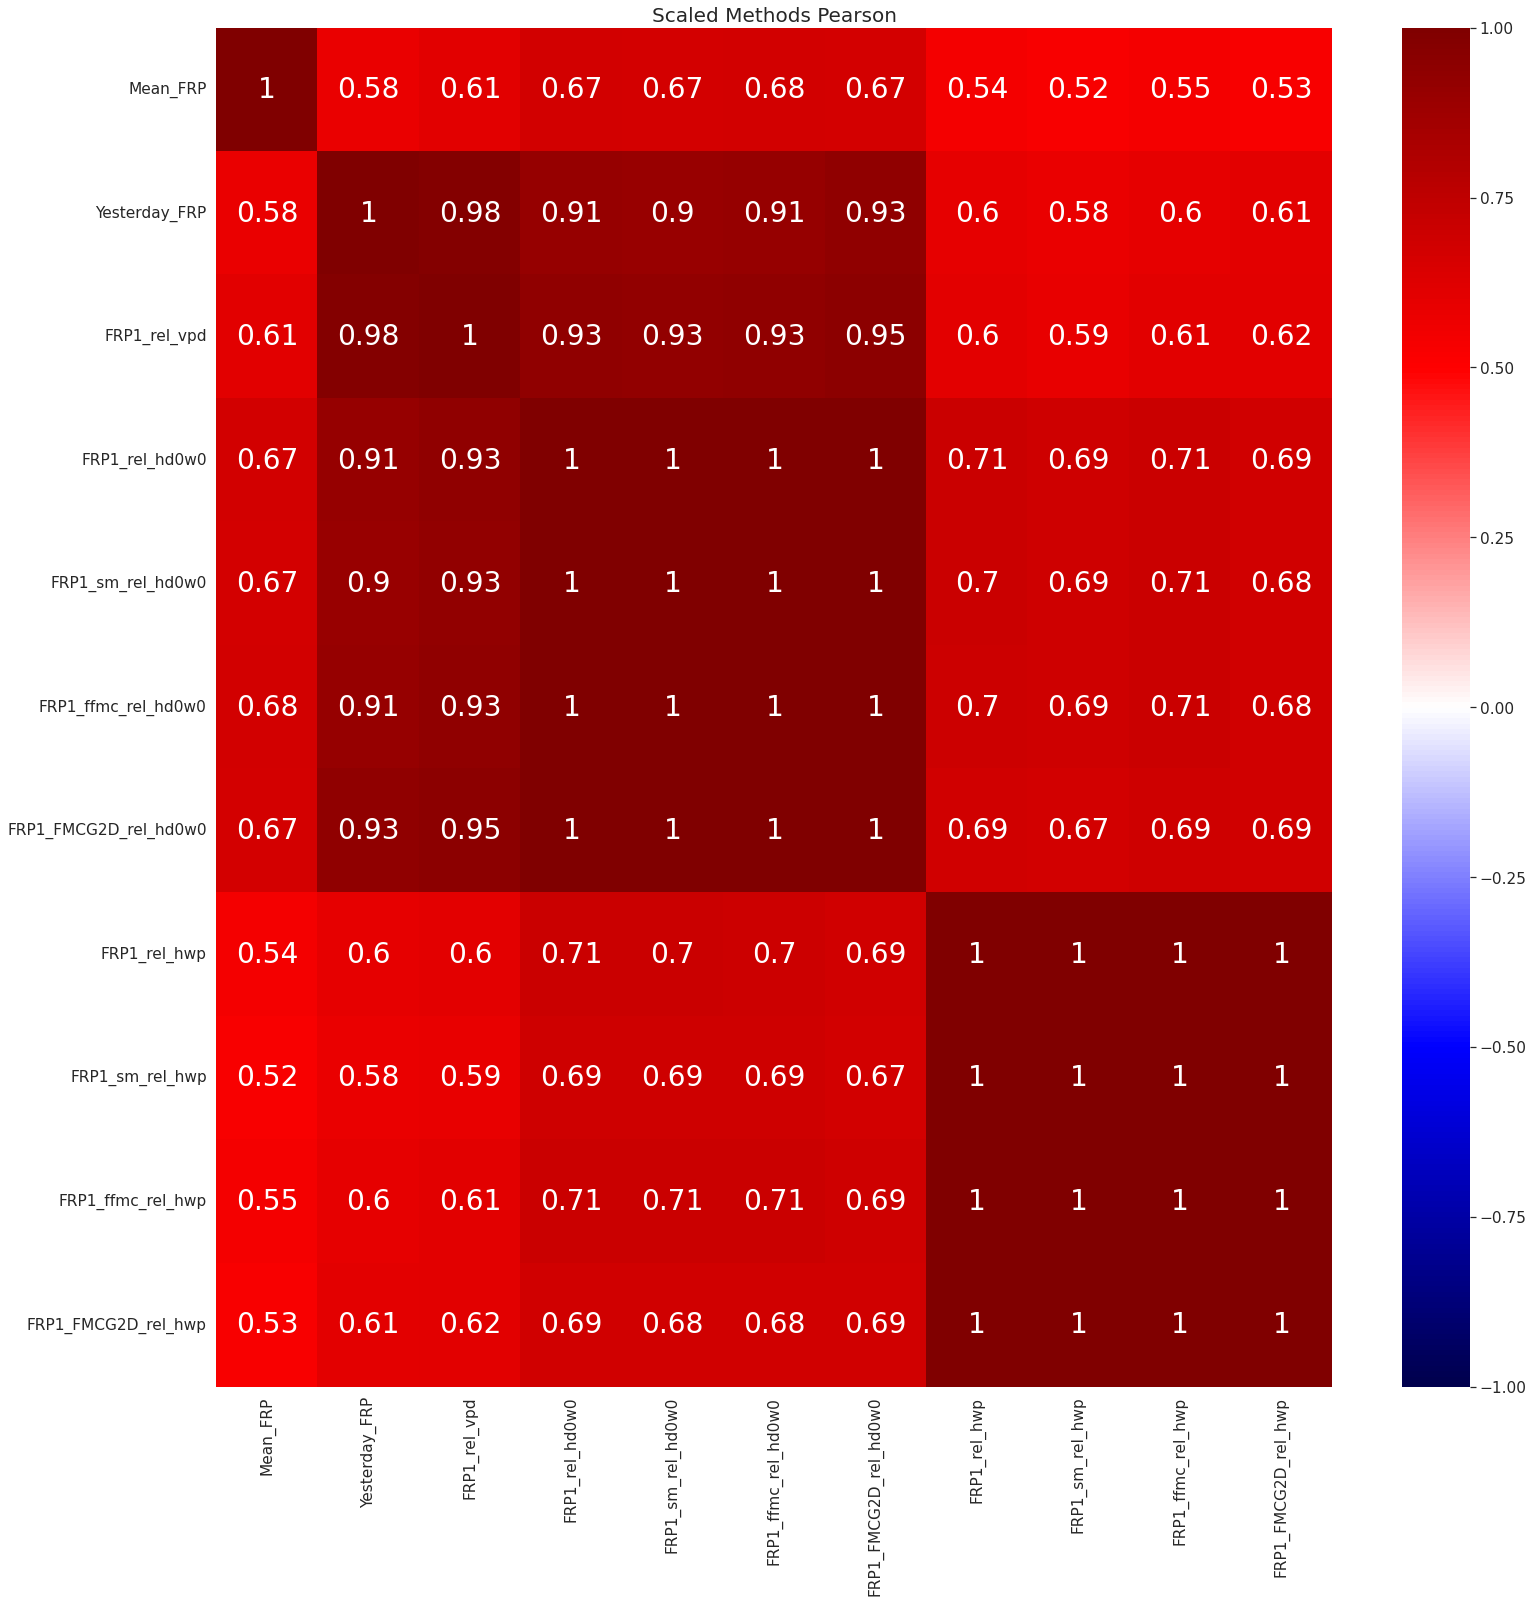

In [8]:
pd.set_option('mode.use_inf_as_na', True)
features_score = features.dropna(axis=0,how='any')
features_scaled = ['Mean_FRP','Yesterday_FRP',
                'FRP1_rel_vpd', #VPD
                'FRP1_rel_hd0w0',
                'FRP1_sm_rel_hd0w0',
                'FRP1_ffmc_rel_hd0w0',
                'FRP1_FMCG2D_rel_hd0w0',
                'FRP1_rel_hwp',
                'FRP1_sm_rel_hwp',
                'FRP1_ffmc_rel_hwp',
                'FRP1_FMCG2D_rel_hwp',
               ]


print('R2 scores:')
print('Scaled method:')
for ii in range(len(features_scaled)):
    print(features_scaled[ii] +' score is: ' + str(r2_score(features_score['Mean_FRP'],features_score[features_scaled[ii]])))

print()
print('RMSE:')
print('Scaled method:')
for ii in range(len(features_scaled)):
    print(features_scaled[ii] +' score is: ' + str(RMSE(features_score['Mean_FRP'],features_score[features_scaled[ii]])))
    
print()
print('Mean Absolute Error:')
print('Scaled method:')
for ii in range(len(features_scaled)):
    print(features_scaled[ii] +' score is: ' + str(MAD(features_score['Mean_FRP'],features_score[features_scaled[ii]])))
    
print()
print('Mean Absolute Error Relative to Persistence:')
print('Scaled method:')
for ii in range(len(features_scaled)):
    print(features_scaled[ii] +' score is: ' + str(mdrae(features_score['Mean_FRP'], 
                                                         features_score[features_scaled[ii]], 
                                                         features_score['Yesterday_FRP'])) )
print()
print('AUC:')
print('Scaled method: ')
for ii in range(len(features_scaled)):
    thresh, acc = REC(features_score[features_scaled[ii]], features_score['Mean_FRP'])
    print(features_scaled[ii] +' score is: ' + str(AUC(acc) ))

    
plot_correlations(features[features_scaled], 'Scaled Methods Pearson', 'pearson')


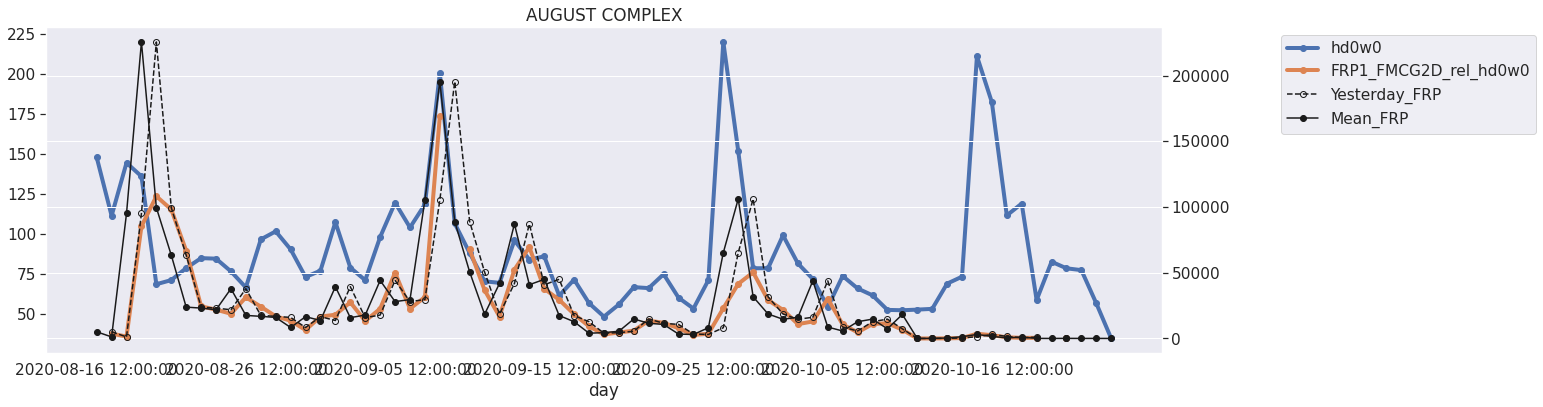

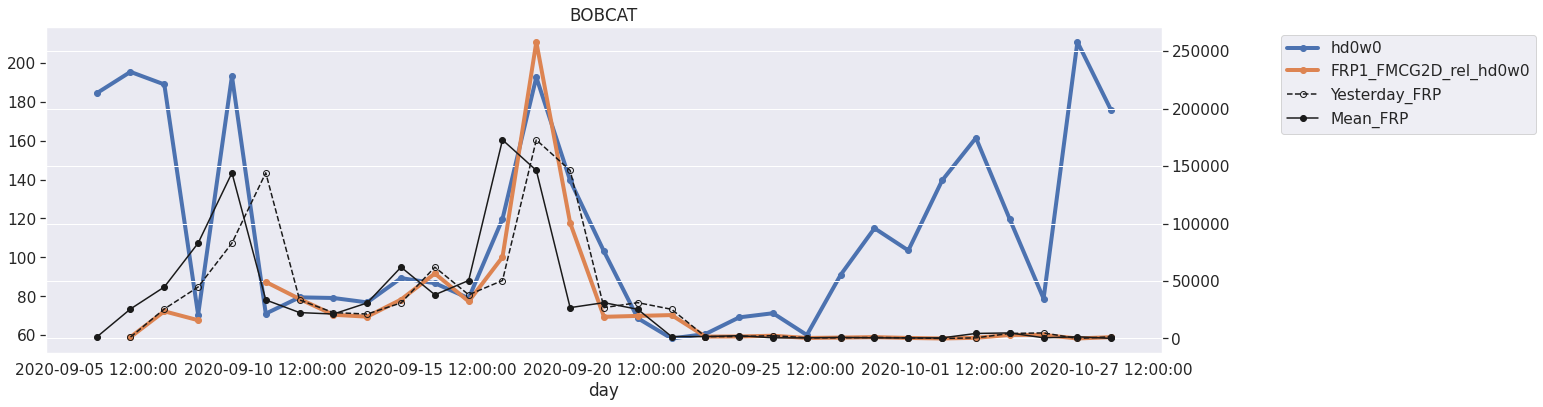

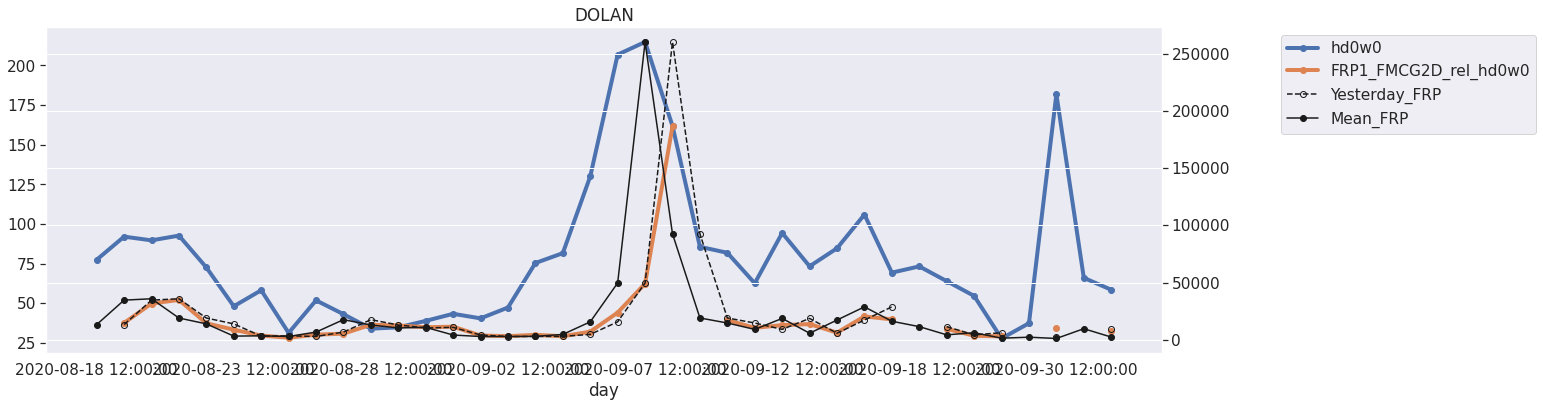

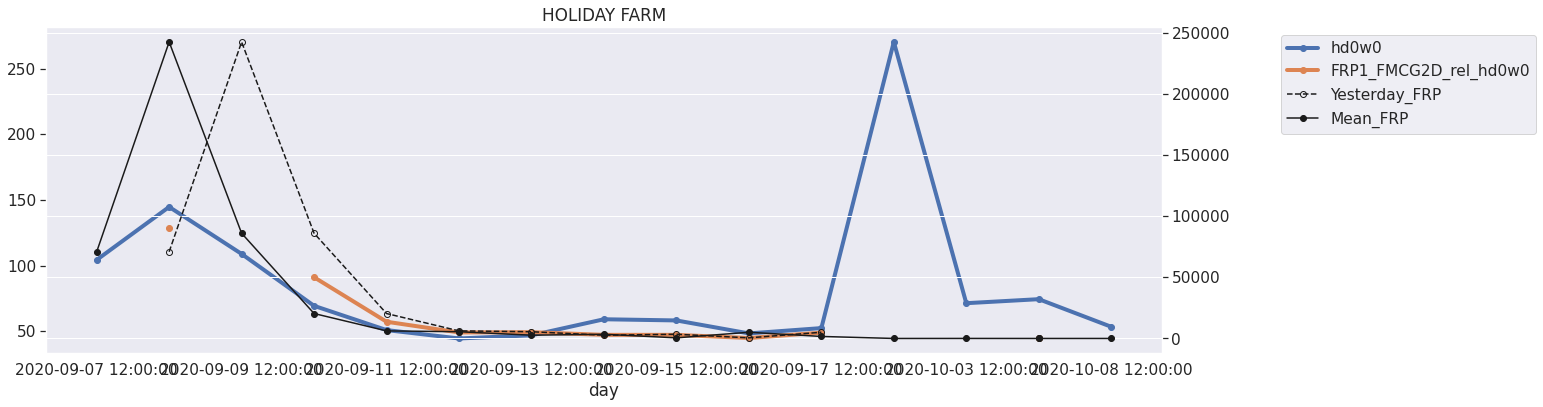

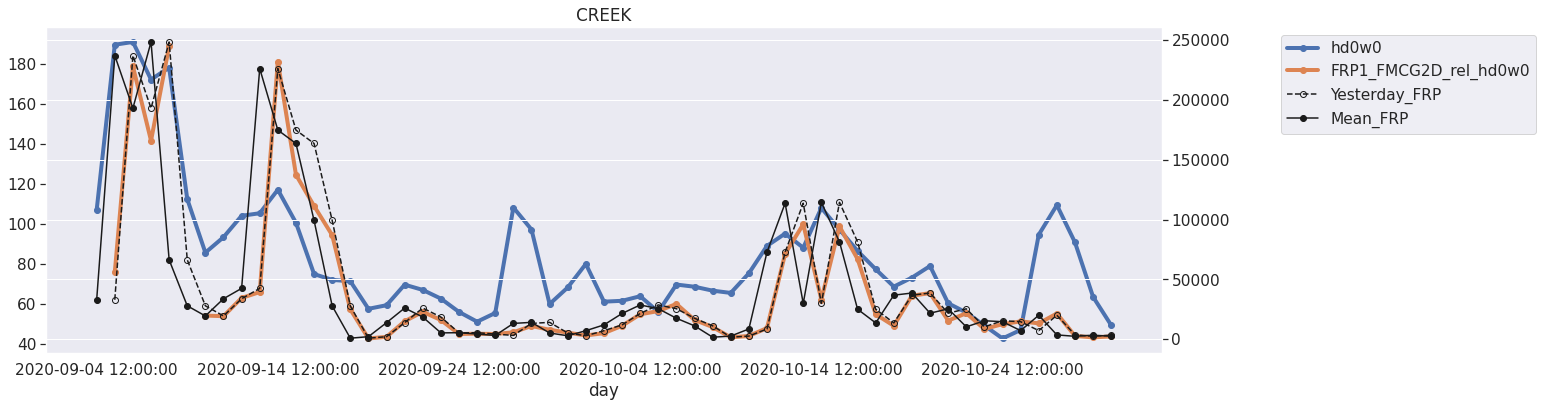

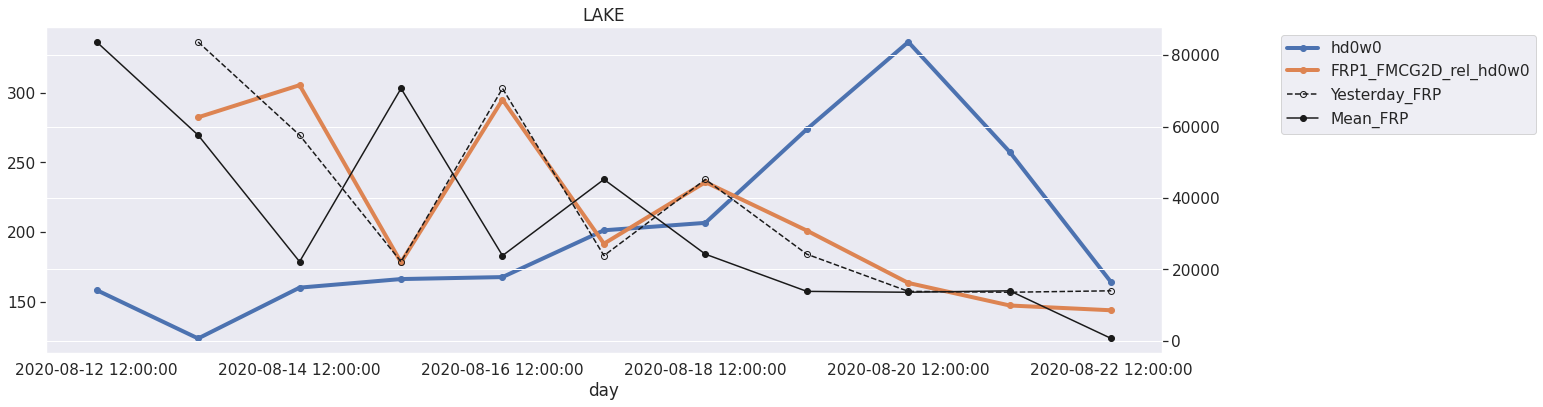

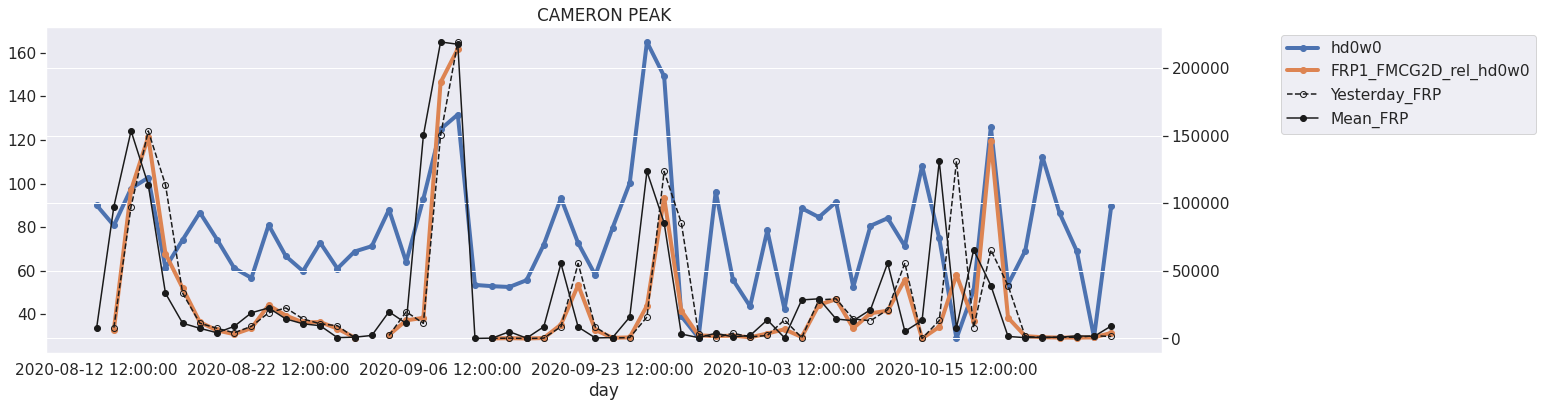

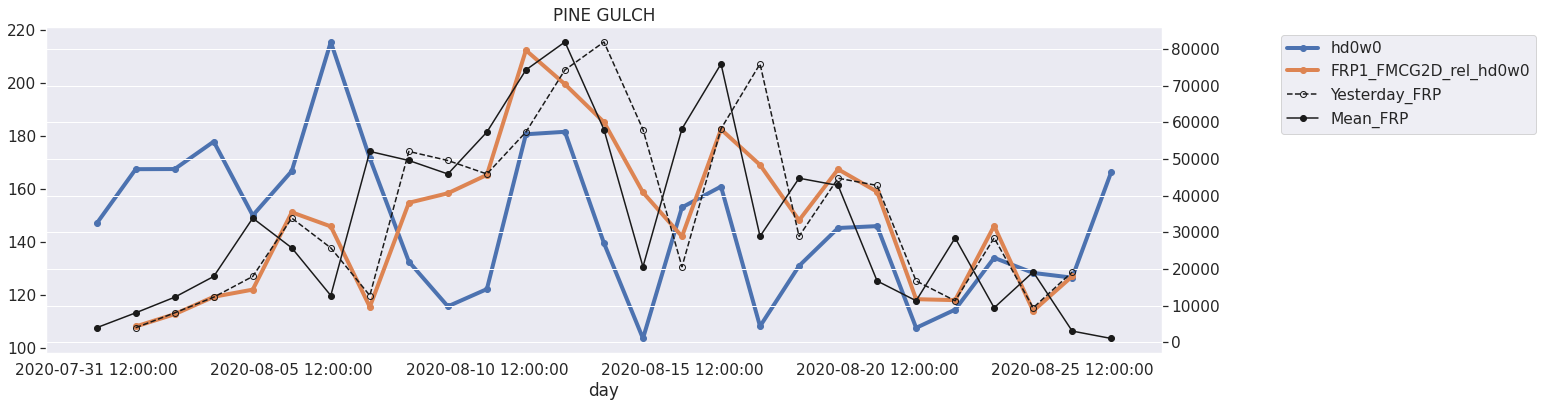

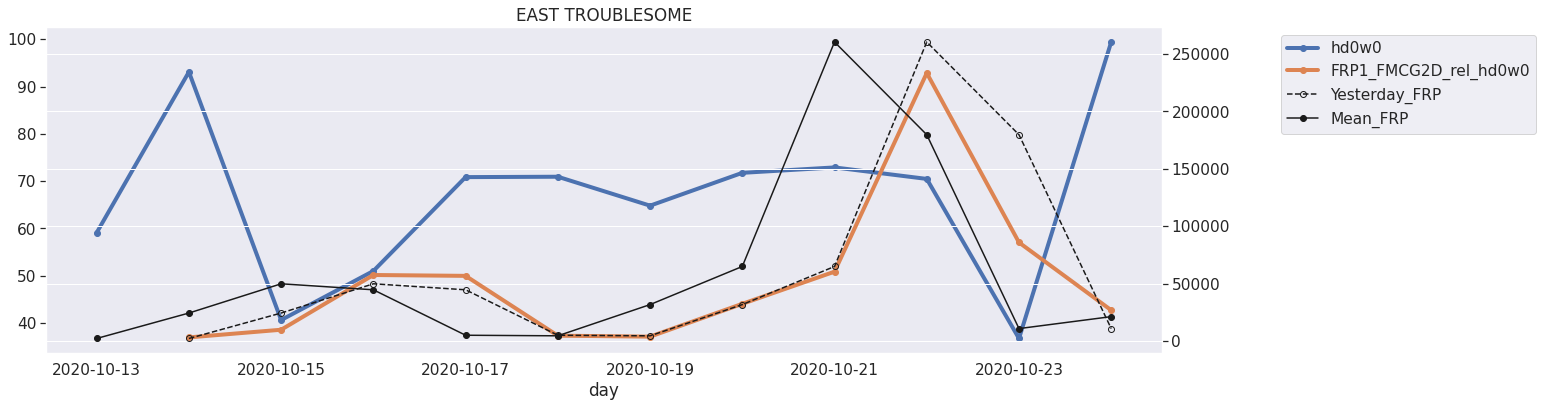

In [83]:
for ii in range(len(inci_name_list)):
    features_plot = features[features['name']==inci_name_list[ii]]
    #print(features_plot)
    fig, ax = plt.subplots(figsize=(20,15)) 
    features_plot.plot(x='day', y=['hd0w0',],
                       figsize=(20,6),style='o-',linewidth=4,ax=ax )
    features_plot.plot(x='day', y=['FRP1_FMCG2D_rel_hd0w0'],secondary_y=True,
                       figsize=(20,6),style='o-',linewidth=4,ax=ax )
    features_plot.plot(x='day', y=['Yesterday_FRP'],secondary_y=True,
                       figsize=(20,6),style='ko--',fillstyle='none',ax=ax )
    features_plot.plot(x='day', y=['Mean_FRP'],secondary_y=True,
                       figsize=(20,6),style='ko-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax.right_ax.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(inci_name_list[ii])
    plt.show()